# Example how to normalize, iterate over data

In [1]:
import logging
import shutil
import errno
import tempfile
from os import environ

In [2]:
environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

import sys
sys.path.append("/home/rkube/repos/frnn-loader")

import matplotlib.pyplot as plt

In [4]:
from frnn_loader.backends.fetchers import fetcher_d3d_v1
from frnn_loader.backends.backend_hdf5 import backend_hdf5
from frnn_loader.primitives.filters import filter_ip_thresh
from frnn_loader.primitives.resamplers import resampler_causal
from frnn_loader.primitives.signal import signal_0d
from frnn_loader.primitives.normalizers import mean_std_normalizer
from frnn_loader.loaders.frnn_dataset_disk import shot_dataset_disk
from frnn_loader.loaders.frnn_multi_dataset import frnn_multi_dataset
from frnn_loader.loaders.frnn_loader import batched_random_sequence_sampler


from frnn_loader.utils.errors import SignalCorruptedError, NotDownloadedError

In [5]:
# Directory where all project data files are to be stored
root = "/projects/FRNN/frnn_loader"

# 1/ Describe the dataset
predictor_tags = [
    "q95",
    "efsli",
    "ipspr15V",
    "efsbetan",
    "efswmhd",
    "dusbradial",
    "dssdenest",
    "pradcore",
    "pradedge",
    "bmspinj",
    "bmstinj",
    "ipsiptargt",
    "ipeecoil",
]
predictor_list = [signal_0d(tag) for tag in predictor_tags]

# Contains a list of shots that are non-disruptive
shotlist_clear = [167475, 167481]
# Contains a list of shots that are disruptive
shotlist_disrupt = [167480, 167487]


shotdict = {167475: {"tmin": 0.0, "tmax": 2000.0, "is_disruptive": False, "t_disrupt": -1000.0},
            167481: {"tmin": 0.0, "tmax": 2000.0, "is_disruptive": False, "t_disrupt": -1000.0},
            167480: {"tmin": 0.0, "tmax": 5037.5, "is_disruptive": True, "t_disrupt": 5037.5},
            167487: {"tmin": 0.0, "tmax": 2159.0, "is_disruptive": True, "t_disrupt": 2159.0}}

In [6]:
cuda = torch.device("cuda:1")

In [7]:
y = torch.tensor([1., 2.]).cuda()

In [8]:
# Instantiate the filter we use to crimp the shot times
ip_filter = filter_ip_thresh(0.2)
signal_ip = signal_0d("ipspr15V")
my_backend = backend_hdf5(root)
my_fetcher = fetcher_d3d_v1()

In [9]:
for shotnr in shotlist_clear + shotlist_disrupt:

    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(shotdict[shotnr]["tmin"], shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=root,
        download=True,
        normalizer=None,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32,
    )

In [10]:
#########################################################################################################
#
# Next we create a list of datasets for all shots.
# The shots are cut to the time intervals defined by tmin and tmax
# A normalizer is calculated from these datasets.
# After the normalizer has been calculated the hdf5 files generated by
# these dataset are to be deleted using ds.delete_data_file

dset_unnormalized_list = []
for shotnr in tqdm(shotdict.keys()):
    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=root,
        download=True,
        normalizer=None,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32)

    dset_unnormalized_list.append(ds)

100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]


In [11]:
#########################################################################################################
#
# With all datasets cropped to the correct time in place we continue by calculating the normalization.
# Do this using multi-processing
my_normalizer = mean_std_normalizer()
my_normalizer.fit(dset_unnormalized_list)

print(my_normalizer.mean_all)
print(my_normalizer.std_all)

tensor([ 6.7887e+00,  1.0386e+00,  1.6655e+00,  1.3938e+00,  4.6827e+05,
         6.6149e-01,  2.6404e+00,  9.5968e-04,  8.8882e-04,  4.0299e+03,
         3.1282e+00,  1.6871e+00, -3.0600e-02])
tensor([2.5413e+00, 2.3883e-01, 4.6736e-01, 9.8530e-01, 3.5295e+05, 4.8426e-01,
        1.3253e+00, 1.4020e-03, 8.2292e-04, 2.7770e+03, 2.2637e+00, 4.8875e-01,
        5.4498e-02])


In [12]:
# With a normalizer at hand, we can now safely delete the datafiles from the
# un-normalized shots.
# Then re-instantiate the datasets using the trained normalizer
dset_normalized_list = []
for shotnr in tqdm(shotdict.keys()):

    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=root,
        download=True,
        normalizer=my_normalizer,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32,
    )
    dset_normalized_list.append(ds)

dset_work = frnn_multi_dataset(dset_normalized_list)

100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s]


In [13]:
for i in range(4):
    print(dset_work[i][:][0].shape)
    print(dset_work[i][:][1].shape)

torch.Size([2000, 13])
torch.Size([2000, 1])
torch.Size([2000, 13])
torch.Size([2000, 1])
torch.Size([5038, 13])
torch.Size([5038, 1])
torch.Size([2159, 13])
torch.Size([2159, 1])


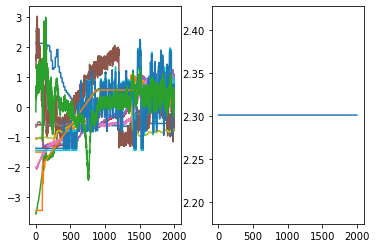

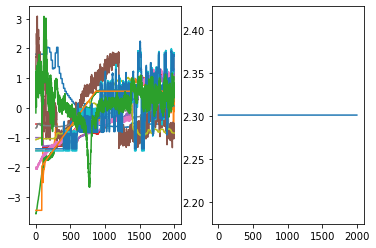

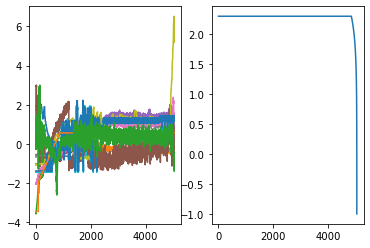

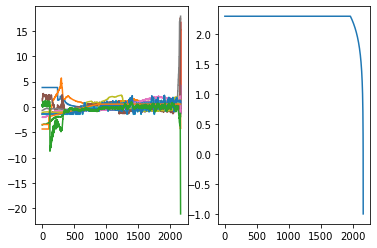

In [14]:
for i in range(4):
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(dset_work[i][:][0]);
    plt.subplot(1,2,2)
    plt.plot(dset_work[i][:][1]);

In [15]:
def my_collate_fn(input):
    """Reshape list of inputs to torch.tensor

    Input is a list of length 1. The only element is the list returned
    by frnn_multi_dataset.__getitem__

    We
    """
    X_vals = torch.stack([t[0] for t in input[0]])
    Y_vals = torch.stack([t[1] for t in input[0]])

    return X_vals, Y_vals

In [28]:
# This sampler pulls a batch of `batch_size` sequences, each of length `seq_length
# from the dataset. The sequences start at random places and are uniformly distributed
# over the shots of the dataset.
my_sampler = batched_random_sequence_sampler(dset_work, seq_length=400, batch_size=8)
# Default pytorch dataloader. Batch shape is defined through my_sampler
# my_collate_fn is used to transform output from dataset.__getitem__ to a torch.tensor
my_loader = DataLoader(dset_work, sampler=my_sampler, collate_fn=my_collate_fn)

In [29]:
# Set up a simple model. Use parameters in plasma-python/examples/conf.yaml
# And model construction written in plasma/models/builder.py, build_model

class SimpleLSTM(nn.Module):
    """Simple LSTM for TTD prediction."""
    def __init__(self, size_in):
        super(SimpleLSTM, self).__init__()
        self.size_in = size_in
        self.pre_rnn = nn.Sequential(
            nn.Linear(self.size_in, 128),
            nn.ReLU(),
            nn.Linear(128, 128//2),
            nn.ReLU(),
            nn.Linear(128//2, 128//4)
        )
        
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM
        self.lstm = nn.LSTM(128//4, 32, num_layers=2, batch_first=True)
        self.final = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.pre_rnn(x)
        # LSTM has 3 outputs.
        # 1. X
        # 2. h
        # 3. c
        x, h_c = self.lstm(x)
        x = self.final(x)
        
        return x

In [30]:
model = SimpleLSTM(13).cuda()
print(model)

SimpleLSTM(
  (pre_rnn): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (final): Linear(in_features=32, out_features=1, bias=True)
)


In [31]:
# Set up training:
num_epochs = 30

# Loss function
loss_fn = nn.MSELoss()
# Optimizer
opt = optim.Adam(model.parameters(), weight_decay=1e-4)

Epoch   1: loss=2.041388e+01
Epoch  11: loss=2.521110e-01
Epoch  21: loss=3.801248e-02


Text(0, 0.5, 'MSE loss')

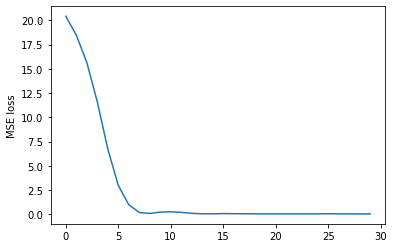

In [32]:
# Iterate over training set
loss_vec = np.zeros(num_epochs)

for epoch in range(num_epochs):
    loss_epoch = 0.0
    num_batches = 0
    for num_batch, XY in enumerate(my_loader):
        X, Y = XY
        X = X.cuda()
        Y = Y.cuda()
        opt.zero_grad()
        
        output = model(X[:, :-1, :])
        loss = loss_fn(output, Y[:, 1:, :])
        loss.backward()
        opt.step()
        num_batches += 1

        loss_epoch += loss.item()
    if epoch % 10 == 0:   
        print(f"Epoch {(epoch+1):3d}: loss={(loss_epoch):8.6e}")
    loss_vec[epoch] = loss_epoch
    
plt.plot(loss_vec)
plt.ylabel("MSE loss")

In [33]:
i = 0
for xy in my_loader:
    X, Y = XY
    print(X.shape)
    i = i + 1 #break
print(i)
Y_pred = model(X.cuda()).cpu()

torch.Size([3, 400, 13])
torch.Size([3, 400, 13])
torch.Size([3, 400, 13])
torch.Size([3, 400, 13])
4


In [34]:
X.shape

torch.Size([3, 400, 13])

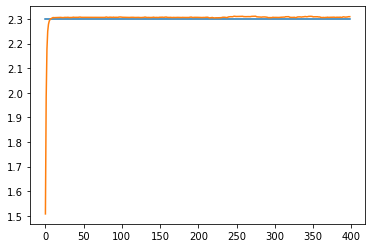

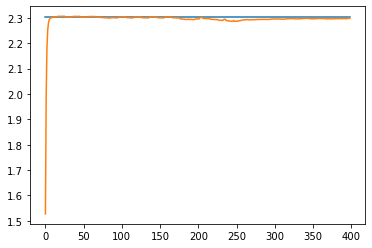

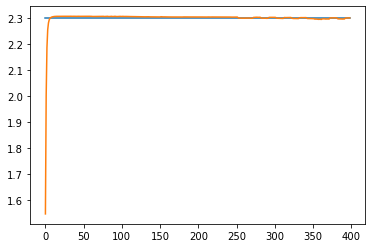

In [35]:
for i in range(Y.shape[0]):
    plt.figure()
    plt.plot(Y[i, 1:, 0].detach().cpu().numpy())
    plt.plot(Y_pred[i, 1:, 0].detach().cpu().numpy())